In [1]:
%load_ext autoreload
%autoreload 2
from data_util import *
from metric_util import *
from train_util import *
from model import *

import torch 
import pickle
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.models import resnet18
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import GCL.losses as L
from GCL.models import DualBranchContrast
from GCL.eval import get_split, LREvaluator
import GCL.augmentors as A


In [2]:
config = {
    # meta config
    'dataset_name': 'pokecn',
    'sens_name': 'age',
    'conditional': True,
    'debias': True,
    'adversarial': False,
    # tunable config
    'batch_size': 256 * 16,
    'hidden_dim': 240*5,
    'drop_prob': 0.2,
    'cond_temp': 1.0/800,
    'debias_temp': 1.0/80,
    'debias_ratio': 80,
    'lr': 0.001,
    'tau': 0.1,
}

In [3]:
# some more config setting
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

dataset_name = config['dataset_name']
sens_name = config['sens_name']
sens_num = 2 if sens_name in ['gender', 'region'] else 1 # for adv predic
TASK_TYPE = 'regression' if dataset_name=='crimes' else 'classification'

In [4]:
# load dataset...
dataset = get_dataset(dataset_name, sens_name)
#x = dataset[:][0]
#sens = dataset[:][2]
sample_index = None
if dataset_name in ['pokecn', 'pokecz']:
    g, sens, sample_index = get_samples(dataset, num=5000)
else:
    g, sens = get_samples(dataset, num=5000)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=3)

Loading region_job_2 dataset from /data/qf31/FCL/datasets/pokec
self.edge_index:  torch.Size([2, 1100663])


In [5]:
# prepare model config
input_dim = dataset.input_dim #dataset[0][0].shape[-1]
hidden_dim = config['hidden_dim'] if config['dataset_name'] != 'celeba' else 1000
sens_dim = dataset.sens_dim

In [6]:
# create model
main_encoder = GConv(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=3)
sens_encoder = MLP(sens_dim,hidden_dim)
adv_model = Adv_sens(sens_num=sens_num, hidden_dim=hidden_dim)

#aug = transforms.Compose([transforms.RandomCrop(size=RESIZE), transforms.ColorJitter(),
#                         transforms.Grayscale(num_output_channels=3), transforms.RandomHorizontalFlip(),
#                         transforms.RandomVerticalFlip()])#FeatureDrop(drop_prob=config['drop_prob'])

aug = A.Compose([A.EdgeAdding(0.2), A.EdgeRemoving(0.2), A.FeatureMasking(0.2)])

encoder_model = Encoder(main_encoder = main_encoder, augmentor = aug, sens_encoder = sens_encoder, adv_model=adv_model)
encoder_model = encoder_model.to(device)

In [7]:
contrast_model = DualBranchContrast(loss=L.FairInfoNCE(tau=config['tau']), mode='G2G').to(device)
optim = Adam(encoder_model.parameters(), lr=config['lr'])

performance_list = []
gdp_hist_list = []
gdp_max_list = []
gdp_kernel_list = []

epoch = 100
with tqdm(total=epoch, desc='(T)') as pbar:
    for epoch in range(1, epoch+1):
        encoder_model = encoder_model.to(device)
        loss_result = train(encoder_model = encoder_model, contrast_model=contrast_model,
                                         dataloader=dataloader, optimizer = optim,
                                         conditional=config['conditional'],debias=config['debias'], adversarial=config['adversarial'] if epoch%5==0 else False,
                                         cond_temp = config['cond_temp'],
                                         debias_temp = config['debias_temp'],
                                         debias_ratio = config['debias_ratio'])
        pbar.set_postfix({'loss': loss_result['loss'], 
                          'conditional_loss':loss_result['conditional_loss'], 
                          'debias_loss': loss_result['debias_loss'],
                          'adv_loss': loss_result['adv_loss']})
        pbar.update()

        if epoch % 1 == 0:
            print(loss_result)
            result, evaluator = test(encoder_model, dataloader, evaluator=LREvaluator(task=TASK_TYPE))
            classifier = result['classifier']
            
            # performance 
            performance = result['mae'] if dataset_name=='crimes' else result['auc']
            print('performance: ', performance)
            performance_list.append(performance)
        
            # fairness
            gdp_hist, gdp_kernel, gdp_max = gdp(g=g, sens=sens, sample_index=sample_index, task=TASK_TYPE, hist_num=1000, encoder_model=encoder_model, classifier=classifier)
            print('hist gdp: ', gdp_hist)
            gdp_hist_list.append(gdp_hist)
            print('max gdp: ', gdp_max)
            gdp_max_list.append(gdp_max)
            print('kernel gdp: ', gdp_kernel)
            gdp_kernel_list.append(gdp_kernel)

        
        

(T):   1%|          | 1/100 [00:03<06:26,  3.90s/it, loss=422, conditional_loss=5.03, debias_loss=5.21, adv_loss=0]

{'loss': 421.6158447265625, 'conditional_loss': 5.027059555053711, 'debias_loss': 5.207359790802002, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.71, F1Ma=0.709]


performance:  0.7095226221028637
hist gdp:  0.09027711999999999
max gdp:  1.0
kernel gdp:  0.025816705


(T):   2%|▏         | 2/100 [00:21<19:55, 12.20s/it, loss=341, conditional_loss=5.01, debias_loss=4.2, adv_loss=0] 

{'loss': 341.290283203125, 'conditional_loss': 5.014604568481445, 'debias_loss': 4.203445911407471, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.705, F1Ma=0.704]


performance:  0.704395058222096
hist gdp:  0.0927672
max gdp:  1.0
kernel gdp:  0.025734905


(T):   3%|▎         | 3/100 [00:40<24:12, 14.98s/it, loss=219, conditional_loss=4.85, debias_loss=2.68, adv_loss=0]

{'loss': 219.20907592773438, 'conditional_loss': 4.849369049072266, 'debias_loss': 2.6794962882995605, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.704, F1Ma=0.704]


performance:  0.7038839064765797
hist gdp:  0.08462528
max gdp:  1.0
kernel gdp:  0.025363209


(T):   4%|▍         | 4/100 [00:58<25:59, 16.24s/it, loss=168, conditional_loss=4.9, debias_loss=2.04, adv_loss=0] 

{'loss': 168.1033172607422, 'conditional_loss': 4.895772933959961, 'debias_loss': 2.0400943756103516, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.708, F1Ma=0.708]


performance:  0.7081269819520025
hist gdp:  0.09154559999999999
max gdp:  1.0
kernel gdp:  0.025128277


(T):   5%|▌         | 5/100 [01:16<26:46, 16.91s/it, loss=196, conditional_loss=4.88, debias_loss=2.39, adv_loss=0]

{'loss': 196.1072540283203, 'conditional_loss': 4.876855850219727, 'debias_loss': 2.3903799057006836, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:16<00:00, best test F1Mi=0.707, F1Ma=0.707]


performance:  0.7067167264328147
hist gdp:  0.08967423999999999
max gdp:  1.0
kernel gdp:  0.025721513


(T):   6%|▌         | 6/100 [01:34<27:16, 17.41s/it, loss=168, conditional_loss=4.72, debias_loss=2.04, adv_loss=0]

{'loss': 167.58419799804688, 'conditional_loss': 4.722285270690918, 'debias_loss': 2.035773754119873, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:16<00:00, best test F1Mi=0.702, F1Ma=0.702]


performance:  0.7020967070055428
hist gdp:  0.08485376000000001
max gdp:  1.0
kernel gdp:  0.027017796


(T):   7%|▋         | 7/100 [01:53<27:32, 17.77s/it, loss=130, conditional_loss=4.48, debias_loss=1.57, adv_loss=0]

{'loss': 130.16070556640625, 'conditional_loss': 4.475064277648926, 'debias_loss': 1.5710705518722534, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.708, F1Ma=0.707]


performance:  0.7074043654643463
hist gdp:  0.08391624
max gdp:  1.0
kernel gdp:  0.02608387


(T):   8%|▊         | 8/100 [02:11<27:29, 17.93s/it, loss=111, conditional_loss=4.88, debias_loss=1.32, adv_loss=0]

{'loss': 110.51725769042969, 'conditional_loss': 4.875019073486328, 'debias_loss': 1.3205280303955078, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.711, F1Ma=0.711]


performance:  0.711172312372737
hist gdp:  0.08916280000000003
max gdp:  1.0
kernel gdp:  0.026623758


(T):   9%|▉         | 9/100 [02:29<27:17, 17.99s/it, loss=69.5, conditional_loss=5.03, debias_loss=0.805, adv_loss=0]

{'loss': 69.47457885742188, 'conditional_loss': 5.034913063049316, 'debias_loss': 0.8054958581924438, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.709, F1Ma=0.709]


performance:  0.7084944227736792
hist gdp:  0.08506160000000001
max gdp:  1.0
kernel gdp:  0.024527665


(T):  10%|█         | 10/100 [02:47<27:05, 18.06s/it, loss=58, conditional_loss=5.01, debias_loss=0.662, adv_loss=0] 

{'loss': 57.98072052001953, 'conditional_loss': 5.005904674530029, 'debias_loss': 0.6621851921081543, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:16<00:00, best test F1Mi=0.72, F1Ma=0.72]


performance:  0.7195289671937805
hist gdp:  0.08415232000000003
max gdp:  1.0
kernel gdp:  0.024064777


(T):  11%|█         | 11/100 [03:06<26:56, 18.16s/it, loss=44.9, conditional_loss=4.71, debias_loss=0.503, adv_loss=0]

{'loss': 44.92578887939453, 'conditional_loss': 4.714120864868164, 'debias_loss': 0.5026458501815796, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.706, F1Ma=0.706]


performance:  0.7062491074365578
hist gdp:  0.08509520000000002
max gdp:  1.0
kernel gdp:  0.02590443


(T):  12%|█▏        | 12/100 [03:24<26:41, 18.20s/it, loss=45.1, conditional_loss=5.12, debias_loss=0.499, adv_loss=0]

{'loss': 45.05440902709961, 'conditional_loss': 5.117806911468506, 'debias_loss': 0.4992075562477112, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.703, F1Ma=0.702]


performance:  0.7023313127905214
hist gdp:  0.08330848
max gdp:  1.0
kernel gdp:  0.02450058


(T):  13%|█▎        | 13/100 [03:42<26:23, 18.20s/it, loss=33, conditional_loss=4.7, debias_loss=0.354, adv_loss=0]   

{'loss': 33.00742721557617, 'conditional_loss': 4.70175838470459, 'debias_loss': 0.3538208603858948, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:16<00:00, best test F1Mi=0.714, F1Ma=0.713]


performance:  0.7131598612945905
hist gdp:  0.08508832000000001
max gdp:  1.0
kernel gdp:  0.025590822


(T):  14%|█▍        | 14/100 [04:01<26:07, 18.23s/it, loss=37.1, conditional_loss=4.89, debias_loss=0.403, adv_loss=0]

{'loss': 37.09943771362305, 'conditional_loss': 4.890974998474121, 'debias_loss': 0.4026057720184326, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.714, F1Ma=0.714]


performance:  0.7138479237826512
hist gdp:  0.08544128000000002
max gdp:  1.0
kernel gdp:  0.026122313


(T):  15%|█▌        | 15/100 [04:19<25:49, 18.23s/it, loss=28.4, conditional_loss=5.79, debias_loss=0.282, adv_loss=0]

{'loss': 28.361526489257812, 'conditional_loss': 5.791796684265137, 'debias_loss': 0.28212159872055054, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.711, F1Ma=0.71]


performance:  0.7103759556166066
hist gdp:  0.08265472
max gdp:  1.0
kernel gdp:  0.025277007


(T):  16%|█▌        | 16/100 [04:37<25:31, 18.24s/it, loss=28.5, conditional_loss=5.59, debias_loss=0.286, adv_loss=0]

{'loss': 28.505462646484375, 'conditional_loss': 5.592588424682617, 'debias_loss': 0.286410927772522, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.711, F1Ma=0.71]


performance:  0.7108742483916857
hist gdp:  0.08332416000000001
max gdp:  1.0
kernel gdp:  0.024761975


(T):  17%|█▋        | 17/100 [04:55<25:07, 18.16s/it, loss=27.4, conditional_loss=5.19, debias_loss=0.278, adv_loss=0]

{'loss': 27.44562530517578, 'conditional_loss': 5.186161041259766, 'debias_loss': 0.2782433032989502, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.712, F1Ma=0.712]


performance:  0.7115742093082229
hist gdp:  0.085428
max gdp:  1.0
kernel gdp:  0.025151746


(T):  18%|█▊        | 18/100 [05:13<24:40, 18.06s/it, loss=19.3, conditional_loss=4.6, debias_loss=0.184, adv_loss=0] 

{'loss': 19.290468215942383, 'conditional_loss': 4.604080677032471, 'debias_loss': 0.18357984721660614, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.716, F1Ma=0.716]


performance:  0.7160002413561133
hist gdp:  0.08795000000000001
max gdp:  1.0
kernel gdp:  0.024877427


(T):  19%|█▉        | 19/100 [05:31<24:13, 17.94s/it, loss=21.2, conditional_loss=5.78, debias_loss=0.193, adv_loss=0]

{'loss': 21.201679229736328, 'conditional_loss': 5.784917831420898, 'debias_loss': 0.19270950555801392, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.708, F1Ma=0.707]


performance:  0.7071502886599783
hist gdp:  0.08440000000000002
max gdp:  1.0
kernel gdp:  0.026006699


(T):  20%|██        | 20/100 [05:48<23:52, 17.91s/it, loss=19.5, conditional_loss=4.64, debias_loss=0.185, adv_loss=0]

{'loss': 19.450403213500977, 'conditional_loss': 4.639420032501221, 'debias_loss': 0.1851373016834259, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.703, F1Ma=0.703]


performance:  0.7029205970818021
hist gdp:  0.08586680000000002
max gdp:  1.0
kernel gdp:  0.025161084


(T):  21%|██        | 21/100 [06:06<23:28, 17.83s/it, loss=16.3, conditional_loss=5.57, debias_loss=0.134, adv_loss=0]

{'loss': 16.285232543945312, 'conditional_loss': 5.571357250213623, 'debias_loss': 0.13392344117164612, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.71, F1Ma=0.71]


performance:  0.7096916970527214
hist gdp:  0.08514944000000002
max gdp:  1.0
kernel gdp:  0.0252541


(T):  22%|██▏       | 22/100 [06:24<23:10, 17.82s/it, loss=15.5, conditional_loss=4.71, debias_loss=0.135, adv_loss=0]

{'loss': 15.467759132385254, 'conditional_loss': 4.70711612701416, 'debias_loss': 0.13450804352760315, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.716, F1Ma=0.715]


performance:  0.7152310485173627
hist gdp:  0.08562672000000002
max gdp:  1.0
kernel gdp:  0.025293974


(T):  23%|██▎       | 23/100 [06:42<22:50, 17.80s/it, loss=16.7, conditional_loss=4.96, debias_loss=0.147, adv_loss=0]

{'loss': 16.71355628967285, 'conditional_loss': 4.9638519287109375, 'debias_loss': 0.14687129855155945, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.71, F1Ma=0.71]


performance:  0.7101182537544173
hist gdp:  0.08630000000000003
max gdp:  1.0
kernel gdp:  0.025042715


(T):  24%|██▍       | 24/100 [06:59<22:33, 17.81s/it, loss=13.8, conditional_loss=4.97, debias_loss=0.11, adv_loss=0] 

{'loss': 13.753801345825195, 'conditional_loss': 4.970794200897217, 'debias_loss': 0.10978759080171585, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.712, F1Ma=0.712]


performance:  0.7115837909417704
hist gdp:  0.08222639999999999
max gdp:  1.0
kernel gdp:  0.024004387


(T):  25%|██▌       | 25/100 [07:17<22:14, 17.79s/it, loss=13.6, conditional_loss=5.4, debias_loss=0.103, adv_loss=0]

{'loss': 13.611981391906738, 'conditional_loss': 5.400469779968262, 'debias_loss': 0.10264389216899872, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.711, F1Ma=0.71]


performance:  0.7106084262768962
hist gdp:  0.08415000000000002
max gdp:  1.0
kernel gdp:  0.024447536


(T):  26%|██▌       | 26/100 [07:35<21:54, 17.76s/it, loss=12.6, conditional_loss=4.79, debias_loss=0.0979, adv_loss=0]

{'loss': 12.624848365783691, 'conditional_loss': 4.790748119354248, 'debias_loss': 0.09792625159025192, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.717, F1Ma=0.717]


performance:  0.7173302241217967
hist gdp:  0.08792640000000002
max gdp:  1.0
kernel gdp:  0.025624065


(T):  27%|██▋       | 27/100 [07:53<21:36, 17.76s/it, loss=12.8, conditional_loss=4.86, debias_loss=0.0987, adv_loss=0]

{'loss': 12.753997802734375, 'conditional_loss': 4.860448837280273, 'debias_loss': 0.09866935759782791, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.713, F1Ma=0.713]


performance:  0.7132777302290713
hist gdp:  0.08944408000000004
max gdp:  1.0
kernel gdp:  0.02524705


(T):  28%|██▊       | 28/100 [08:11<21:22, 17.82s/it, loss=13.1, conditional_loss=5.16, debias_loss=0.0989, adv_loss=0]

{'loss': 13.071462631225586, 'conditional_loss': 5.159753799438477, 'debias_loss': 0.09889635443687439, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.711, F1Ma=0.711]


performance:  0.7108970572248874
hist gdp:  0.08460759999999999
max gdp:  1.0
kernel gdp:  0.025045559


(T):  29%|██▉       | 29/100 [08:28<21:06, 17.84s/it, loss=11.8, conditional_loss=5.35, debias_loss=0.0806, adv_loss=0]

{'loss': 11.796106338500977, 'conditional_loss': 5.345510482788086, 'debias_loss': 0.08063244819641113, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.715, F1Ma=0.715]


performance:  0.7148506504876626
hist gdp:  0.08779448000000001
max gdp:  1.0
kernel gdp:  0.026072219


(T):  30%|███       | 30/100 [08:46<20:47, 17.82s/it, loss=10.9, conditional_loss=4.89, debias_loss=0.0756, adv_loss=0]

{'loss': 10.935030937194824, 'conditional_loss': 4.88726806640625, 'debias_loss': 0.07559703290462494, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.71, F1Ma=0.71]


performance:  0.7102214482507876
hist gdp:  0.08760704000000002
max gdp:  1.0
kernel gdp:  0.024547162


(T):  31%|███       | 31/100 [09:04<20:29, 17.82s/it, loss=12.2, conditional_loss=6.13, debias_loss=0.0756, adv_loss=0]

{'loss': 12.185466766357422, 'conditional_loss': 6.133700847625732, 'debias_loss': 0.07564707100391388, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.72, F1Ma=0.719]


performance:  0.7190929369127591
hist gdp:  0.08848256
max gdp:  1.0
kernel gdp:  0.024916107


(T):  32%|███▏      | 32/100 [09:22<20:12, 17.83s/it, loss=11.5, conditional_loss=5.55, debias_loss=0.074, adv_loss=0] 

{'loss': 11.465937614440918, 'conditional_loss': 5.5463361740112305, 'debias_loss': 0.07399501651525497, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:15<00:00, best test F1Mi=0.713, F1Ma=0.713]


performance:  0.7125863079363185
hist gdp:  0.08336512000000001
max gdp:  1.0
kernel gdp:  0.024069097


(T):  33%|███▎      | 33/100 [09:40<19:53, 17.82s/it, loss=11.5, conditional_loss=5.98, debias_loss=0.0694, adv_loss=0]

{'loss': 11.533473014831543, 'conditional_loss': 5.983745574951172, 'debias_loss': 0.06937159597873688, 'adv_loss': 0.0}


# graph data draft

In [19]:
from torch_geometric.datasets import Planetoid

In [20]:
dataset = Planetoid(root='./datasets', name='Cora', split='random')

In [22]:
(dataset[0].edge_index)

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [42]:
dataset = 'region_job'
sens_attr = 'region' #'AGE'
predict_attr = 'spoken_languages_indicator'#'I_am_working_in_field'(negative value in) 'spoken_languages_indicator'
path="./datasets/pokec/"
sens_number=500
seed=19
test_idx=False
import scipy.sparse as sp
print('Loading {} dataset from {}'.format(dataset,path))

idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
header = list(idx_features_labels.columns)
header.remove("user_id")

header.remove(sens_attr)
header.remove(predict_attr)


features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
labels = idx_features_labels[predict_attr].values
labels[np.where(labels > 0)] = 1 # transfer I_am_working_in_field into binary task


# build graph
idx = np.array(idx_features_labels["user_id"], dtype=int)
idx_map = {j: i for i, j in enumerate(idx)}
edges_unordered = np.genfromtxt(os.path.join(path,"{}_relationship.txt".format(dataset)), dtype=int)

edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                    dtype=int).reshape(edges_unordered.shape)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(labels.shape[0], labels.shape[0]),
                    dtype=np.float32)
# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

# features = normalize(features)
adj = adj + sp.eye(adj.shape[0])

features = (np.array(features.todense()))
#labels = torch.LongTensor(labels)
# adj = sparse_mx_to_torch_sparse_tensor(adj)

import random
random.seed(seed)
label_idx = np.where(labels>=0)[0] # some label is -1 null
random.shuffle(label_idx)

idx_train = label_idx[:int(0.5 * len(label_idx))]
idx_val = label_idx[int(0.5 * len(label_idx)):int(0.75 * len(label_idx))]
if test_idx:
    idx_test = label_idx[int(0.5 * len(label_idx)):]
    idx_val = idx_test
else:
    idx_test = label_idx[int(0.75 * len(label_idx)):]

sens = idx_features_labels[sens_attr].values

sens_idx = set(np.where(sens >= 0)[0])
idx_test = np.asarray(list(sens_idx & set(idx_test)))
#sens = torch.FloatTensor(sens)
idx_sens_train = list(sens_idx - set(idx_val) - set(idx_test))
random.seed(seed)
random.shuffle(idx_sens_train)
idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

# random.shuffle(sens_idx)
#return adj, features, labels, sens, idx_train, idx_val, idx_val

Loading region_job dataset from ./datasets/pokec/


In [48]:
features[np.where(features < 0)[0]].shape

(57534, 276)

In [45]:
features[0, 4]

-1.0

In [64]:
len(idx_train) + len(idx_val) + len(idx_test)

67796

In [43]:
np.expand_dims(sens, axis=1)

(67796, 1)

In [44]:
MinMaxScaler().fit_transform(StandardScaler().fit_transform(np.expand_dims(sens, axis=1)))

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]])

In [33]:
MinMaxScaler().fit_transform(StandardScaler().fit_transform([features[:, 1]]))

array([[0., 0., 0., ..., 0., 0., 0.]])

In [55]:
edges

array([[    0,     3],
       [    0,     2],
       [    0,    11],
       ...,
       [35254, 33604],
       [35275, 44261],
       [35336, 34505]])

In [86]:
torch.from_numpy(np.stack([adj.tocoo().row, adj.tocoo().col], axis=0)).long()

tensor([[    0,     0,     0,  ..., 67795, 67795, 67795],
        [    0,     2,     3,  ..., 57955, 61427, 67795]])

In [70]:
sens?

Type:        Tensor
String form: tensor([0., 1., 0.,  ..., 1., 0., 1.])
Length:      67796
File:        ~/anaconda3/envs/graph2/lib/python3.9/site-packages/torch/__init__.py
Docstring:   <no docstring>


In [13]:
labels?

Type:        Tensor
String form: tensor([-1, -1,  1,  ..., -1,  1, -1])
Length:      67796
File:        ~/anaconda3/envs/graph2/lib/python3.9/site-packages/torch/__init__.py
Docstring:   <no docstring>


In [14]:
torch.unique(labels)

tensor([-1,  0,  1])

(array([2.1264e+04, 1.9968e+04, 1.8102e+04, 5.6090e+03, 1.3430e+03,
        2.1700e+02, 1.5000e+01, 6.0000e+00, 1.3000e+01, 3.2000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

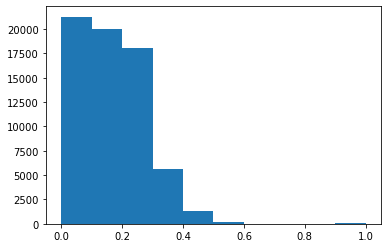

In [13]:
from matplotlib import pyplot as plt
plt.hist(sens.numpy())

In [41]:
import dgl
from utils import feature_norm
# g = dgl.DGLGraph()
g = dgl.from_scipy(adj)
g = g.to(device)

ModuleNotFoundError: No module named 'dgl'

In [28]:
label_idx?

Type:        ndarray
String form: [15836 41916  8624 ... 67042 15818  5669]
Length:      67796
File:        /data/qf31/anaconda3/envs/graph/lib/python3.9/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
----------
(for the __new__ method; see Notes below)

shape : tuple of ints
    Shape of created a

In [9]:
labels?

Type:        Tensor
String form: tensor([1, 1, 1,  ..., 0, 0, 0])
Length:      67796
File:        /data/qf31/anaconda3/envs/graph/lib/python3.9/site-packages/torch/__init__.py
Docstring:   <no docstring>


In [14]:
idx?

Type:        ndarray
String form: [      1  131075       5 ... 1572853 1572859  393212]
Length:      67796
File:        /data/qf31/anaconda3/envs/graph/lib/python3.9/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
----------
(for the __new__ method; see Notes below)

shape : tuple of ints
    Shape 